In [1]:
import dask.dataframe as dd
import pandas as pd
from distributed import Client, progress, wait

In [2]:
client = Client(n_workers=6)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 31.29 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34479,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.29 GiB
Comm: tcp://127.0.0.1:37469,Total threads: 2
Dashboard: http://127.0.0.1:35671/status,Memory: 5.21 GiB
Nanny: tcp://127.0.0.1:43389,


In [3]:
# Naive method ~3GB
# 2023-06
# 3.11.2 conda - 51s
# 2023-11
# 3.11.5 conda - 43.7s
# 3.11.6 - 44.1s
# 3.12.0 - 41s

fuel_type_ddf = (
    dd.read_parquet(
        "../../test_result.parquet",
        dtype_backend="pyarrow",
    )
    .query('test_result == "P"')
    .replace({"fuel_type": {"Hybrid Electric (Clean)": "HY", "Electric": "EL"}})
    .assign(Year=lambda x: x.test_date.dt.year)
    .groupby(["Year", "fuel_type"])
    .agg({"test_result": "count"})
    .rename(columns={"test_result": "vehicle_count"})
    .persist()
)

progress(fuel_type_ddf)

VBox()

In [4]:
# PyArrow part optimised method ~1.7GB
# 34s
# Less RAM, less time
# 24.6s

fuel_type_ddf = (
    dd.read_parquet(
        "../../test_result.parquet",
        dtype_backend="pyarrow",
        columns=["test_result", "test_date", "fuel_type"],
        # filters=[("test_result", "==", "P")],
    )
    .query('test_result == "P"')
    .replace({"fuel_type": {"Hybrid Electric (Clean)": "HY", "Electric": "EL"}})
    .assign(Year=lambda x: x.test_date.dt.year)
    .groupby(["Year", "fuel_type"])
    .agg({"test_result": "count"})
    .rename(columns={"test_result": "vehicle_count"})
    .persist()
)

progress(fuel_type_ddf)

VBox()

In [5]:
# PyArrow optimised method ~1.7GB
# 29-32s
# Less RAM, less time
# 22.2s

fuel_type_ddf = (
    dd.read_parquet(
        "../../test_result.parquet",
        dtype_backend="pyarrow",
        columns=["test_result", "test_date", "fuel_type"],
        filters=[("test_result", "==", "P")],
    )
    .replace({"fuel_type": {"Hybrid Electric (Clean)": "HY", "Electric": "EL"}})
    .assign(Year=lambda x: x.test_date.dt.year)
    .groupby(["Year", "fuel_type"])
    .agg({"test_result": "count"})
    .rename(columns={"test_result": "vehicle_count"})
    .persist()
)

progress(fuel_type_ddf)

VBox()

In [6]:
fuel_type_df = fuel_type_ddf.compute().pivot_table(
    values="vehicle_count",
    index="Year",
    columns="fuel_type",
    aggfunc="sum",
    fill_value=0,
)

fuel_type_df.head()

fuel_type,CN,DI,ED,EL,FC,GA,GB,GD,HY,LN,LP,OT,PE,ST
Year,,,,,,,,,,,,,,
2005,11,1258805,0,335,3,20,121,0,25,18,7030,125,4098561,26
2006,61,5438952,0,1699,20,50,481,1,152,53,31308,693,17368825,89
2007,54,5973332,0,2539,36,56,584,1,381,66,32428,1159,17411739,104
2008,56,6448408,0,4660,85,54,682,2,1129,65,32569,2367,17174571,110
2009,58,7008115,0,7980,133,57,733,3,2424,68,31810,4276,17086268,122


Text(0, 0.5, 'Count (million)')

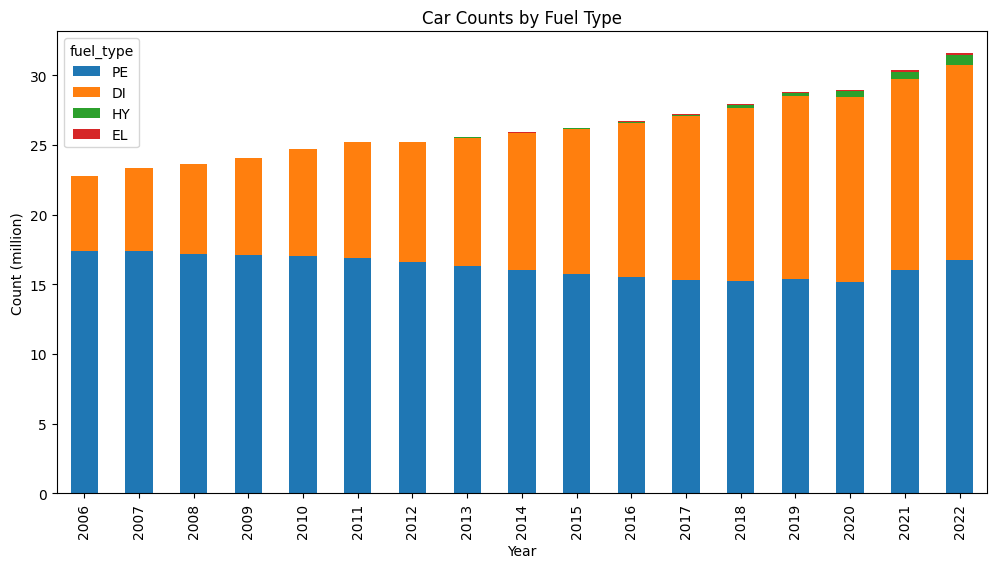

In [7]:
ax = (
    fuel_type_df.loc[2006:, ["PE", "DI", "HY", "EL"]]
    .div(1000000)
    .reset_index()
    .plot.bar(figsize=(12, 6), x="Year", stacked=True, title="Car Counts by Fuel Type")
)
ax.set_ylabel("Count (million)")